Regression Implementation


In [1]:
import wfdb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy.interpolate import interp1d

Loading and normalizing datasets

In [2]:


# Function to load EMG data
def load_emg_data(subject, session, finger_number, sample_number):
    emg_record_name = f"1dof_force_finger{finger_number}_sample{sample_number}"
    emg_record_path = f"hd-semg/1.0.0/1dof_dataset/{subject}_{session}"
    emg_record = wfdb.rdrecord(emg_record_name, pn_dir=emg_record_path)
    emg_data = emg_record.p_signal  
    return emg_data

# Function to load force data
def load_force_data(subject, session, finger_number, sample_number):
    force_record_name = f"1dof_force_finger{finger_number}_sample{sample_number}"
    force_record_path = f"hd-semg/1.0.0/1dof_dataset/{subject}_{session}"
    force_record = wfdb.rdrecord(force_record_name, pn_dir=force_record_path)
    force_data = force_record.p_signal 
    return force_data

# Function to normalize data
def normalize_data(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    return normalized_data, scaler

# selecting parameters
subject = 'subject01'
session = 'session1'
finger_number = 1
sample_number = 1

# Load EMG and force data
emg_data = load_emg_data(subject, session, finger_number, sample_number)
force_data = load_force_data(subject, session, finger_number, sample_number)

# Normalize EMG and force data
normalized_emg, emg_scaler = normalize_data(emg_data)
normalized_force, force_scaler = normalize_data(force_data)

# Print the shapes of the normalized data
print("Normalized EMG shape:", normalized_emg.shape)
print("Normalized Force shape:", normalized_force.shape)


Normalized EMG shape: (2500, 5)
Normalized Force shape: (2500, 5)


Applying sequencing function

In [3]:


def extract_windows_for_subjects(subjects, session, channels, window_size=100, overlap=0.5):
    windows_dict = {}

    for subject in subjects:
        # Load the dataset
        record_name = f"1dof_preprocess_finger1_sample1"
        record_path = f"hd-semg/1.0.0/1dof_dataset/{subject}_{session}"
        record_emg = wfdb.rdrecord(record_name, pn_dir=record_path)

        # Extract signals for selected channels
        signals = record_emg.p_signal[:, channels]

        # Calculate the number of samples for the given window size and overlap
        window_step = int(window_size * (1 - overlap))
        num_windows = (signals.shape[0] - window_size) // window_step + 1

        # Initialize the 3D array to store windows
        windows = np.zeros((num_windows, window_size, len(channels)))

        # Extract windows
        for i in range(num_windows):
            start = i * window_step
            end = start + window_size
            windows[i, :, :] = signals[start:end, :]

        windows_dict[subject] = windows

    return windows_dict

# subject usage:
selected_subjects = ['subject01', 'subject02']
session_id = 'session1'
selected_channels = [0, 1, 2]
window_size = 100
overlap = 0.5

# Extract windows for selected subjects
extracted_windows_dict = extract_windows_for_subjects(selected_subjects, session_id, selected_channels, window_size, overlap)

# Access windows for each subject and print their shapes
for subject, windows in extracted_windows_dict.items():
    print(f"Subject {subject}: Shape of extracted windows - {windows.shape}")


Subject subject01: Shape of extracted windows - (1023, 100, 3)
Subject subject02: Shape of extracted windows - (1023, 100, 3)


In [4]:


# Windows for each subject
subject1_windows = extracted_windows_dict['subject01']
subject2_windows = extracted_windows_dict['subject02']

# Feature names
feature_names = ['MAV', 'RMS', 'WL', 'IAV', 'Skewness', 'Variance', 'ZCR', 'M2', 'Energy', 'DASDV', 'Kurtosis', 'LOG', 'OHM', 'MAVSLP', 'SSC']

# Function to calculate features for each channel
def calculate_channel_features(window):
    features = []

    # Features
    mav = np.mean(np.abs(window))
    rms = np.sqrt(np.mean(window**2))
    wl = np.sum(np.abs(np.diff(window)))
    iav = np.sum(np.abs(window))
    skewness = np.mean(((window - np.mean(window)) / np.std(window))**3)
    variance = np.var(window)
    zcr = np.sum(np.diff(np.sign(window)) != 0) / (len(window) - 1)
    m2 = np.mean(np.diff(window, 2)**2)
    energy = np.sum(window**2)    
    dasdv = np.sqrt(np.mean(np.diff(window)**2))
    kurt = np.mean(((window - np.mean(window)) / np.std(window))**4)
    log_detector = np.sum(np.log(np.abs(window) + 1))
    ohm = np.sum(np.abs(np.diff(np.angle(np.fft.fft(window)))))
    mavslp = np.mean(np.abs(np.diff(window)))
    ssc = np.sum(np.diff(np.sign(np.diff(window))) != 0)
    ssi = np.sum(window**2)
    tm = np.sum(np.abs(np.diff(window))**2)

    # Selecting 15 features
    features.extend([mav, rms, wl, iav, skewness, variance, zcr, m2, energy, dasdv, kurt, log_detector, ohm, mavslp, ssc])

    return features

# Calculate feature matrix for each EMG channel
num_channels = subject1_windows.shape[2]  
feature_matrices_subject1 = [np.array([calculate_channel_features(window[:, i]) for window in subject1_windows]) for i in range(num_channels)]
feature_matrices_subject2 = [np.array([calculate_channel_features(window[:, i]) for window in subject2_windows]) for i in range(num_channels)]

# Convert feature matrices to pandas DataFrames with actual feature names
feature_df_subject1 = [pd.DataFrame(matrix, columns=feature_names) for matrix in feature_matrices_subject1]
feature_df_subject2 = [pd.DataFrame(matrix, columns=feature_names) for matrix in feature_matrices_subject2]

# Print the shapes of the feature DataFrames
for channel, df in enumerate(feature_df_subject1):
    print(f"Subject1 Channel {channel + 1}: Shape of feature DataFrame - {df.shape}")

for channel, df in enumerate(feature_df_subject2):
    print(f"Subject2 Channel {channel + 1}: Shape of feature DataFrame - {df.shape}")


Subject1 Channel 1: Shape of feature DataFrame - (1023, 15)
Subject1 Channel 2: Shape of feature DataFrame - (1023, 15)
Subject1 Channel 3: Shape of feature DataFrame - (1023, 15)
Subject2 Channel 1: Shape of feature DataFrame - (1023, 15)
Subject2 Channel 2: Shape of feature DataFrame - (1023, 15)
Subject2 Channel 3: Shape of feature DataFrame - (1023, 15)


Remove highly correlated matrix

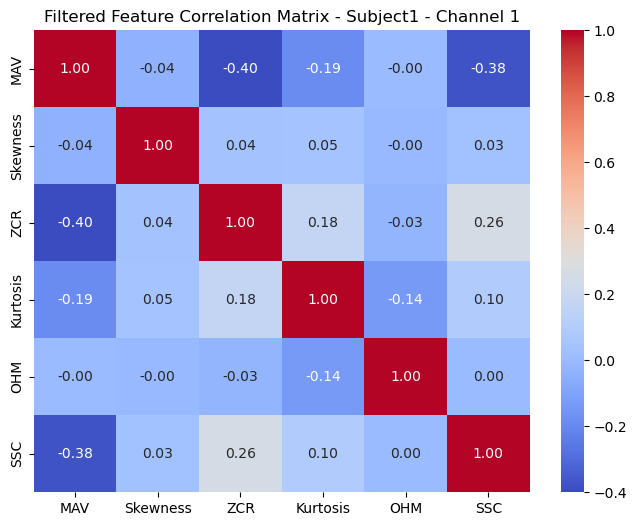

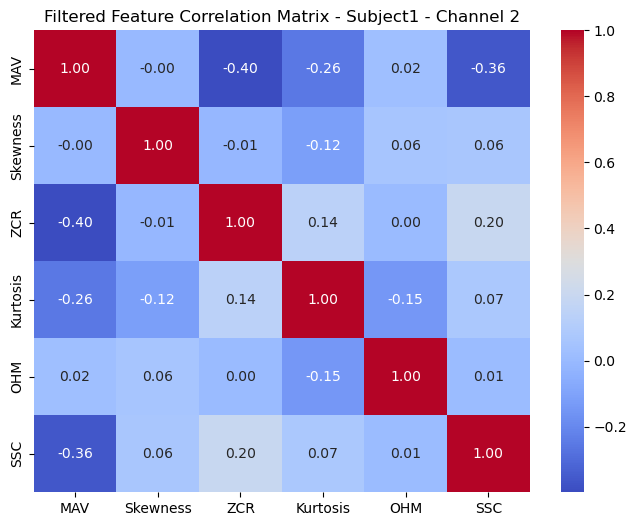

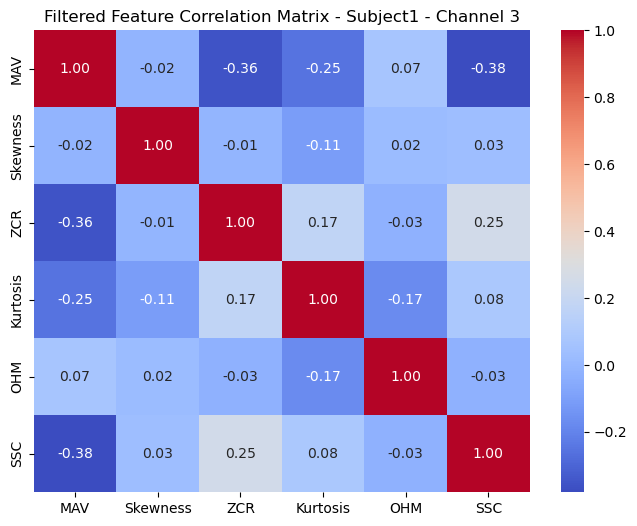

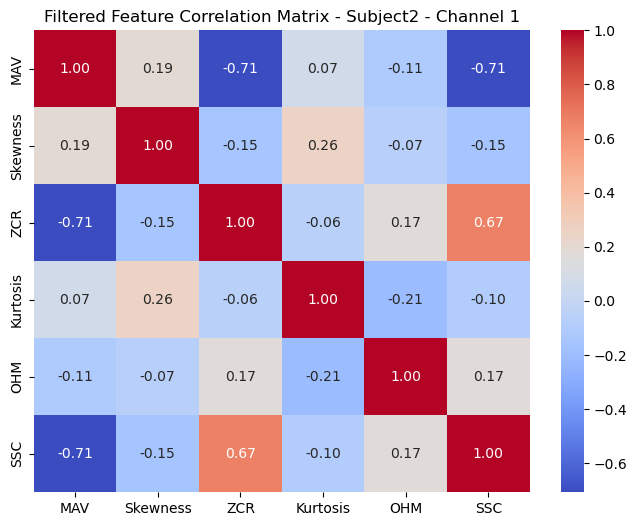

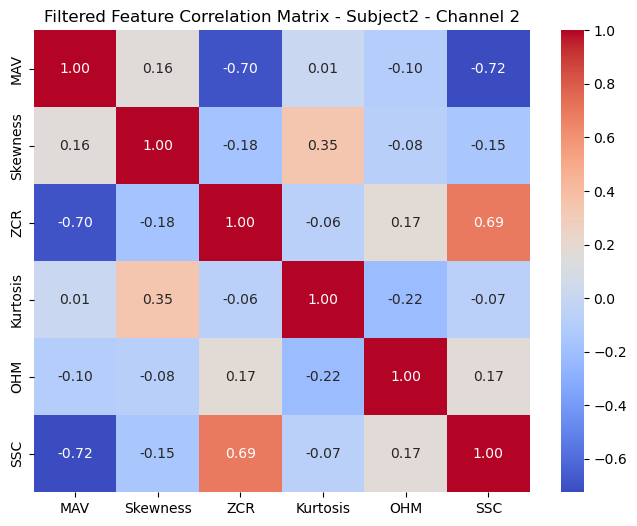

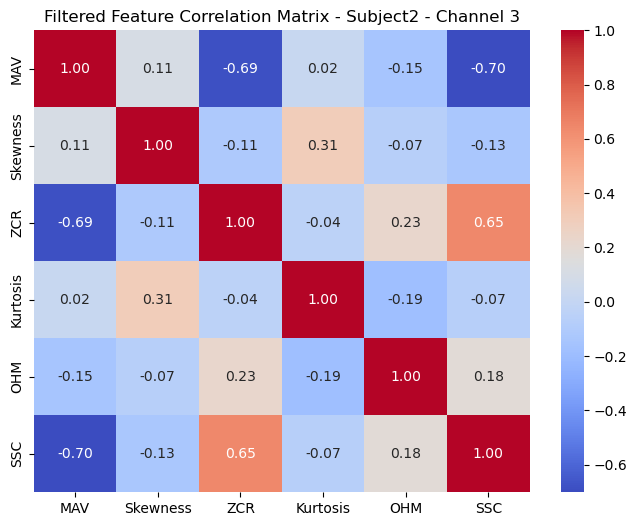

In [5]:
# Calculate feature matrix for each EMG channel
num_channels = subject1_windows.shape[2]  
feature_matrices_subject1 = [np.array([calculate_channel_features(window[:, i]) for window in subject1_windows]) for i in range(num_channels)]
feature_matrices_subject2 = [np.array([calculate_channel_features(window[:, i]) for window in subject2_windows]) for i in range(num_channels)]

# Convert feature matrices to pandas DataFrames with actual feature names
feature_df_subject1 = [pd.DataFrame(matrix, columns=feature_names) for matrix in feature_matrices_subject1]
feature_df_subject2 = [pd.DataFrame(matrix, columns=feature_names) for matrix in feature_matrices_subject2]

# Function to remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.8):
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features
    df_filtered = df.drop(columns=to_drop)

    return df_filtered

# Remove highly correlated features for each channel
filtered_feature_df_subject1 = [remove_highly_correlated_features(df) for df in feature_df_subject1]
filtered_feature_df_subject2 = [remove_highly_correlated_features(df) for df in feature_df_subject2]

# Plot the correlation matrices for the filtered features
for channel, df in enumerate(filtered_feature_df_subject1):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", xticklabels=True, yticklabels=True)
    plt.title(f"Filtered Feature Correlation Matrix - Subject1 - Channel {channel + 1}")
    plt.show()

for channel, df in enumerate(filtered_feature_df_subject2):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", xticklabels=True, yticklabels=True)
    plt.title(f"Filtered Feature Correlation Matrix - Subject2 - Channel {channel + 1}")
    plt.show()

Step 5: creating a train and validation set from X (features) and Y (force) arrays.

In [6]:


# Concatenate the feature matrices for all channels
all_subject1_features = pd.concat(filtered_feature_df_subject1, axis=1).iloc[:2500, :]
all_subject2_features = pd.concat(filtered_feature_df_subject2, axis=1).iloc[:2500, :]

# Defining the target variable (force data)
subject1_force_data = load_force_data('subject01', 'session1', finger_number, sample_number)[:2500, :]
subject2_force_data = load_force_data('subject02', 'session1', finger_number, sample_number)[:2500, :]

# Interpolate the force data to match the EMG window size
def interpolate_force_data(force_data, window_size):
    original_time_points = np.arange(force_data.shape[0])
    new_time_points = np.linspace(0, force_data.shape[0] - 1, all_subject1_features.shape[0])
    
    interpolated_force_data = np.zeros((all_subject1_features.shape[0], force_data.shape[1]))
    for i in range(force_data.shape[1]):
        interp_func = interp1d(original_time_points, force_data[:, i], kind='linear', fill_value='extrapolate')
        interpolated_force_data[:, i] = interp_func(new_time_points)
    
    return interpolated_force_data

subject1_force_data_interpolated = interpolate_force_data(subject1_force_data, window_size)
subject2_force_data_interpolated = interpolate_force_data(subject2_force_data, window_size)

# Concatenate the target variables
all_subject1_targets = np.concatenate([subject1_force_data_interpolated] * num_channels, axis=1)
all_subject2_targets = np.concatenate([subject2_force_data_interpolated] * num_channels, axis=1)

# Split the data into training and validation sets
X_train_subject1, X_val_subject1, y_train_subject1, y_val_subject1 = train_test_split(
    all_subject1_features, all_subject1_targets, test_size=0.2, random_state=42
)

X_train_subject2, X_val_subject2, y_train_subject2, y_val_subject2 = train_test_split(
    all_subject2_features, all_subject2_targets, test_size=0.2, random_state=42
)


5. Fitting the regression curve to the train data 
6. Hyperparameter optimization with the validation set
7. Loading an additional subject as a final test set
8. Evaluating the regression model with the test set

In [7]:

# Define the ridge regressor
ridge_regressor = Ridge()

# Define the hyperparameter grid for λ (0 < λ < 50)
param_grid = {'alpha': np.logspace(-5, 1.69897, 100)}  


# Subject 1 hyperparameter optimization
ridge_grid_subject1 = GridSearchCV(ridge_regressor, param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_grid_subject1.fit(X_train_subject1, y_train_subject1)

# Subject 2 hyperparameter optimization
ridge_grid_subject2 = GridSearchCV(ridge_regressor, param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_grid_subject2.fit(X_train_subject2, y_train_subject2)


# Get the best hyperparameters
best_alpha_subject1 = ridge_grid_subject1.best_params_['alpha']
best_alpha_subject2 = ridge_grid_subject2.best_params_['alpha']

# Train Ridge regressor with the best hyperparameters
ridge_subject1 = Ridge(alpha=best_alpha_subject1)
ridge_subject2 = Ridge(alpha=best_alpha_subject2)

ridge_subject1.fit(X_train_subject1, y_train_subject1)
ridge_subject2.fit(X_train_subject2, y_train_subject2)

# Make predictions on the validation set
y_val_pred_subject1 = ridge_subject1.predict(X_val_subject1)
y_val_pred_subject2 = ridge_subject2.predict(X_val_subject2)

# Evaluate the model on the validation set
rmse_subject1 = np.sqrt(mean_squared_error(y_val_subject1, y_val_pred_subject1))
r2_subject1 = r2_score(y_val_subject1, y_val_pred_subject1)

rmse_subject2 = np.sqrt(mean_squared_error(y_val_subject2, y_val_pred_subject2))
r2_subject2 = r2_score(y_val_subject2, y_val_pred_subject2)

print(f"Subject 1 - RMSE: {rmse_subject1}, R2 Score: {r2_subject1}")
print(f"Subject 2 - RMSE: {rmse_subject2}, R2 Score: {r2_subject2}")


Subject 1 - RMSE: 0.0612749922910464, R2 Score: 0.07244582608087903
Subject 2 - RMSE: 0.03124097318884764, R2 Score: 0.1664830550971414
